<a href="https://colab.research.google.com/github/MitrofanovDmitry/Kaggle/blob/main/%D0%91%D1%83%D1%82%D0%BA%D0%B5%D0%BC%D0%BF_%D0%BF%D1%80%D0%B0%D0%BA%D1%82%D0%B8%D0%BA%D0%B0_BERT_tutorial_01_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT Fine-Tuning with PyTorch



Сегодня мы разберем как использовать языковую модель BERT из библиотеки huggingface PyTorch и научимся его файнтьюнить для задачи классификации предложений. 


Оригинальный пост (by Chris McCormick and Nick Ryan) можно прочитать [здесь](http://mccormickml.com/2019/07/22/BERT-fine-tuning/), а Colab Notebook  найти [здесь](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 



Видео-разбор на Youtube: 

* [Часть 1](https://youtu.be/x66kkDnbzi4) 

* [Часть 2](https://youtu.be/Hnvb9b7a_Ps).




## What is BERT?


BERT — это нейронная сеть от Google, показавшая отличные результаты на целом ряде задач. С помощью BERT можно создавать программы с ИИ для обработки естественного языка: отвечать на вопросы, заданные в произвольной форме, создавать чат-ботов, автоматические переводчики, анализировать текст и так далее.


## Преимущества Fine-Tuning


Если предобучить BERT на больших объемах текста, то он неожиданно и с большим отрывом показывает отличные результаты на множестве самых разных задач по обработке естественного языка. По сути, такая нейронная сеть на выходе создает векторные представления для слов, и даже целых фраз. А навесив сверху над такой языковой моделью небольшой блок из пары дополнительных слоев нейронов, можно дообучить эту нейронную сеть на любые задачи.



# 1. Setup

## 1.1. Использование GPU для обучения



Google Colab предлагает пользователям бесплатные GPU и TPU! Так как мы будет тренировать большие нейросети, GPU нам очень пригодятся! 

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Для того, чтобы библиотека `torch` смогла использовать GPU, необходимо указать этот GPU как `device`. Далее, в процессе тренировки мы отправим модели и данные на этот `device`.

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
device

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


device(type='cuda')

## 1.2. Установка библиотеки Hugging Face 


Теперь давайте установить пакет [transformers](https://github.com/huggingface/transformers) из Hugging Face, который предоставляет удобный интерфейс для работы с BERT'ом и многими другими языковыми моделями. 

В настоящее время библиотека Hugging Face одна из самых популярных pytorch библиотек для работы с трансформерными языковыми моделями. Помимо самих предобученных моделей, библиотека также включает удобный интерфейс для файнтьюнинга и работы с этими моделями для многих задач. Например, сегодня мы будем классифицировать предложения с помощью `BertForSequenceClassification`.

Библиотека также включает классы для классификации токенов, Question-Answering, предсказания следующего предложения и другие. Использование этих классов значительно упрощает работу с моделью.



In [2]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 9.6 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 596 kB 53.5 MB/s 
     |████████████████████████████████| 101 kB 9.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Код в этом ноутбуке - упрощенная версия примера [run_glue.py](https://github.com/huggingface/transformers/blob/master/examples/run_glue.py) из huggingface.



# 2. Загружаем CoLA Dataset


Мы будем работать с [The Corpus of Linguistic Acceptability (CoLA)](https://nyu-mll.github.io/CoLA/) - датасетом для задачи бинарной классификации предложений. Он содержит набор английский предложений с разметкой на 2 класса: *грамматически корректные* и *грамматически некорректные*. 

## 2.1. Загрузка

Воспользуемся пакетом `wget` для скачивания датасета из репозитория.

In [3]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=4e4e2c5079690475a8ce4ef73c1fc1ae2aa521096fe3eabb46b1cc20b5793005
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


Датасет находится в GitHub репозитории: https://nyu-mll.github.io/CoLA/

In [4]:
import wget
import os

print('Downloading dataset...')

# The URL for the dataset zip file.
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# Download the file (if we haven't already)
if not os.path.exists('./cola_public_1.1.zip'):
    wget.download(url, './cola_public_1.1.zip')

Распаковываем данные.

In [6]:
# Unzip the dataset (if we haven't already)
if not os.path.exists('./cola_public/'):
    !unzip cola_public_1.1.zip

## 2.2. Парсинг

Загрузим датасет в DataFrame. 

In [8]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/in_domain_train.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 8,551



,sentence_source,label,label_notes,sentence
2006,rhl07,1,NaN,Fred threw the ball under the porch.
3396,l-93,1,NaN,He waltzed her across the floor.
4102,ks08,0,*,You should avoid to travel in the rush hour.
1123,r-67,0,*,I consider to be a fool the senator who made t...
5931,c_13,1,NaN,John bit the apple.
380,bc01,1,NaN,No candidate can predict how many people will ...
1039,bc01,1,NaN,Exactly half of the students attended some sem...
1028,bc01,1,NaN,Most guests will be offended if we don't invit...
6294,c_13,1,NaN,To be able to buy myself a ticket to France wo...
1774,r-67,1,NaN,The raise which Scrooge generously gave Tom's ...


Нам понадобится только 2 колонки `sentence` и `label`, который отвечает за "acceptibility judgment" (0=unacceptable, 1=acceptable).

Давайте взглянем на несколько примеров.

In [10]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
1961,Bill and Mary washed himself.,0
4723,A mile to work was run by him.,0
1368,We elected employer president the boy's guardi...,0
7986,Medea wondered if that the potion was ready,0
4075,How much money Gordon spent is true.,0


In [12]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

# 3. Токенизация & Форматирование Input 

В данной секции преобразуем данные к формату, с которым работает BERT.

## 3.1. BERT Tokenizer

Чтобы подать на вход текст в BERT'а, его необходимо разбить на токены, а затем закодировать токены их порядковыми индексами в словаре.

Токенизировать предложения необходимо с помощью родного токенайзера модели, иначе может возникнуть путаница с индексами.



In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Применим токенайзер к одному предложению и посмотрим, что получится.


In [15]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Our friends won't buy this analysis, let alone the next one we propose.
Tokenized:  ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs:  [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


Это можно сделать в одно действие с помощью функции `tokenize.encode`, но прежде давайте обсудим требования к форматированию.

## 3.2. Required Formatting


1. Добавить специальные токены начала и конца предложения. 
2. Дополнить & усечь все предложения до одной длины.
3. В явном виде отделить реальные токены от padding-токенов с помощью "attention mask".



### Специальные токены



**`[SEP]`**

В конце каждого предложения необходимо добавить специальный токен `[SEP]`. 




**`[CLS]`**

Для задач классификации в начале каждого предложения необходимо добавить токен `[CLS]`.





### Sentence Length & Attention Mask



Предложения в датасете имеют разную длину. Как же BERT решает эту проблему? 

У BERT'а есть 2 ограничения на входные предложения:
1. Все предложения должны иметь одинаковую фиксированную длину.
2. Максимальная допустимая длина предложений 512 токенов.

Для паддинга используется специальный токен `[PAD]` с индексом 0 в словаре BERT'а. 

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

"Attention Mask" это просто список из 0 и 1, указывающих, какие токены являются PAD-токенами, а какие нет. Эта маска помогает BERT'у  не учитывать PAD-токены при интерпретации предложения.

Также стоит отметить, что максимальная длина предложений влияет на скорость обучения. 
Пример для Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Токенизация данных

В библиотеке transformers есть полезная функция `encode`, с помощью которой удобно токенизировать предложения.

Но перед тем, как закодировать текст, давайте найдем максимальную длину предложений.


В ячейке ниже происходит проход по датасету для определения максимальной длины.

In [17]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  47


Усечем предложения до этой длины.

Все готово для токенизации.

Воспользуемся функцией `tokenizer.encode_plus`, которая выполнит необходимые шаги

1. Разобьет предложения на токены.
2. Добавит специальные токены `[CLS]` и `[SEP]`.
3. Заменит токены на их ID.
4. Приведет все предложения к одной длине - max_len.
5. Создаст attention masks.

Первые четыре свойства также реализованы в функции `tokenizer.encode`, но мы воспольземся `tokenizer.encode_plus`, чтобы получить attention masks (5ое свойство. Документацию можно найти [здесь](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus)).


In [18]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 3.4. Training & Validation Split


Разделим данные на train и val в пропорции  90% к 10%.

In [19]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,695 training samples
  856 validation samples


Также создадим итератор с использование класса  DataLoader из библиотеки torch. 

In [22]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Обучение модели

Теперь, когда данные отформатированы, можем обучить модель. 

## 4.1. BertForSequenceClassification

Для этой задачи воспользуемся модифицированной весией преобученного BERT'а с дополнительным классификационным слоем поверх основной архитектуры.

В библиотеки huggingface для BERT существует целый ряд различных классов для многих типов задач.

Классы для fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

Полную документацию можно почитать [здесь](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



Мы воспользуемся [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). Это обычная модель BERT с добавление одного линейного классификационного слоя поверх основной архитектуры. 



OK, загрузим BERT! На сайте huggingface есть несколько предобученных моделей BERT, мы выберем "bert-base-uncased".

Документацию для метода `from_pretrained` можно почитать [здесь](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), с дополнительными параметрами [здесь](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [23]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

Ради интереса выведем на печать параметры для нескольких слоев:


1. The embedding layer.
2. Первый из 12ти трансформеров.
3. The output layer.




In [24]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Почти все готово для обучения, осталось задать optimizer и sheduler, которые помогут нам с файнтьюном. 

Наиболее популярные конфигурации параметров:
>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

Мы выберем:
* Batch size: 32 (задается при инициализации DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 

Параметр эпсилон `eps = 1e-8` - это "очень маленькое число", которое позволяет избежать деления на 0 (подробнее про него можно прочитать [здесь](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

А пример для AdamW optimizer находится в `run_glue.py` [здесь](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [26]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [28]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Ниже приведена петля обучения (training loop). На каждом проходе по данным мы проходим по всему обучающему и валидационную датасетам. 


**Training:**
- Распаковать обучающие данные и лейблы
- Загрузить данные на GPU для ускорения
- Занулить градиенты с предыдущего шаге 
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Backward pass (backpropagation - посчитать градиенты по всем параметрам с помощью обратного распространения ошибки)
- Обновить параметры с помощью optimizer.step()
- Посчитать статистики, чтобы следить за обучением

**Evaluation:**
- Распаковать валидационные данные и лейблы
- Загрузить данные на GPU для ускорения
- Forward pass (скормить данные в нейросеть и пробросить их вперед)
- Посчитать loss и статистики на валидационных данных, чтобы следить за обучением

Pytorch производит практически все вычисления за нас, нам остается сделать совсем немного. 

Вспомогательная функция для вычисления точности.

In [29]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Вспомогательная функция для отслеживания затраченного времени.


In [30]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


Все готово к обучению! Приступим!

In [31]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        res = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            res = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
        loss = res['loss']
        logits = res['logits']

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:16.
  Batch    80  of    241.    Elapsed: 0:00:31.
  Batch   120  of    241.    Elapsed: 0:00:44.
  Batch   160  of    241.    Elapsed: 0:00:58.
  Batch   200  of    241.    Elapsed: 0:01:11.
  Batch   240  of    241.    Elapsed: 0:01:24.

  Average training loss: 0.49
  Training epcoh took: 0:01:24

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.40
  Validation took: 0:00:03

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    241.    Elapsed: 0:00:13.
  Batch    80  of    241.    Elapsed: 0:00:27.
  Batch   120  of    241.    Elapsed: 0:00:41.
  Batch   160  of    241.    Elapsed: 0:00:54.
  Batch   200  of    241.    Elapsed: 0:01:07.
  Batch   240  of    241.    Elapsed: 0:01:21.

  Average training loss: 0.30
  Training epcoh took: 0:01:21

Running Validation...
  Accuracy: 0.84
  Validation Loss: 0.39
  Validation took: 0:00:03

======== Epoch 3 / 4 ========
Training...
 

Давайте посмотрим на саммари обучающего процесса!

In [32]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.49,0.40,0.83,0:01:24,0:00:03
2,0.30,0.39,0.84,0:01:21,0:00:03
3,0.20,0.45,0.85,0:01:21,0:00:03
4,0.14,0.53,0.85,0:01:21,0:00:03


Обратите внимание, что loss на обучении непрерывно падает, а на валидации начинает возрастать. Это говорит о том, что модель переобучается.

Loss на валидации - более надежный способ, чем accuracy, так как accuracy не зависит от типа ошибки и уверенности классификатора в ответе. 


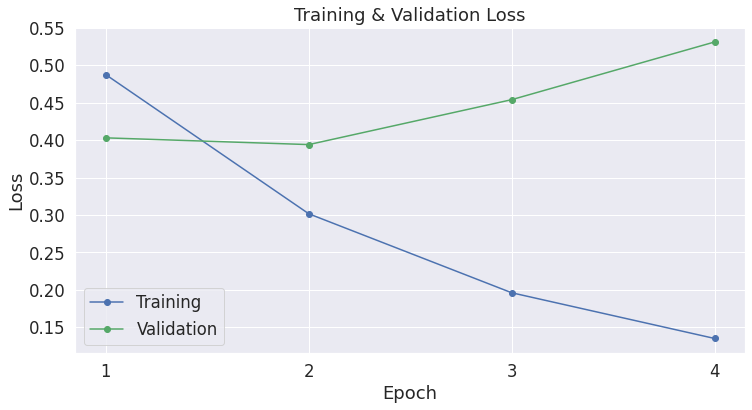

In [33]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# 5. Performance On Test Set

Качество на отложенной выборке. Для оценки качества зафайнтьюненой модели оценим качество на тесте с использованием [Коэффициента корреляции Мэтьюса](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html). Эта метрика традиционно применяется для оценки качества на этом датасете. Корреляция Мэтьюса изменяется от -1 до +1, чем она больше, тем лучше.

### 5.1. Подготовка данных



Применим к тестовым данным те же шаги предобработки данных, которые мы применяли для обучающей и валидационной выборкок.

In [35]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])
df.head()

,sentence_source,label,label_notes,sentence
0,clc95,1,NaN,Somebody just left - guess who.
1,clc95,1,NaN,"They claimed they had settled on something, bu..."
2,clc95,1,NaN,"If Sam was going, Sally would know where."
3,clc95,1,NaN,"They're going to serve the guests something, b..."
4,clc95,1,NaN,She's reading. I can't imagine what.


In [36]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv("./cola_public/raw/out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create sentence and label lists
sentences = df.sentence.values
labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2329: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Оценка на тесте



После того, как мы подготовили тестовые данные, сгенерируем предсказания с использованием дообученной модели.

In [37]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 516 test sentences...
    DONE.


В качестве метрики возьмем [Коэффициент корреляции Мэтьюса](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) (Matthews correlation coefficient, сокращенно MCC).

Данную метрику используют в силу несбалансированности классов в данных:


In [38]:
print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

Positive samples: 354 of 516 (68.60%)


In [39]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


Финальный скор считается по всему датасету, но давайте дополнительно посмотрим на скоры на отдельных батчах. 

Каждый батч кроме последнего содержит 32 предложения 32. Последний содержит только(516 % 32) = 4 тестовых примера.


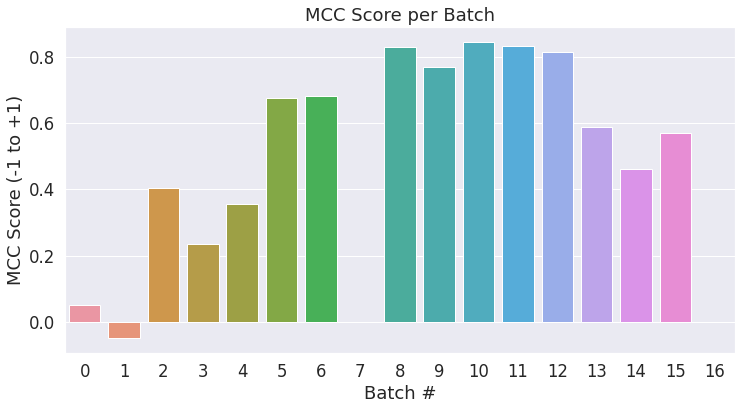

In [40]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Объединим результаты и получим общий MCC скор.

In [41]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.540


**Здорово!** Всего полчаса работы и без всякого тюнинга гиперпараметров (подбора learning rate, числа эпох epochs, размера batch size и т. д.) мы получили такой хороший скор! 


Официальный лидерборд для этого датасета можно найти [здесь](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). 



# Заключение

Мы посмотрели пример работы с предобученной моделью BERT из библиотеки huggingface! Оказывается файнтьюнить большие нейросетки несложно, но очень интересно и полезно ;)

# Appendix


##  Saving & Loading Fine-Tuned Model

Код ниже позволяет сохранить дообученную модель и соотвествующий ей токенайзер на диск. 

In [42]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/tokenizer_config.json',
 './model_save/special_tokens_map.json',
 './model_save/vocab.txt',
 './model_save/added_tokens.json')

Из любопытства проверим размеры файлов. 

In [43]:
!ls -l --block-size=K ./model_save/

total 427984K
-rw-r--r-- 1 root root      1K Aug  1 22:26 config.json
-rw-r--r-- 1 root root 427741K Aug  1 22:26 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug  1 22:26 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug  1 22:26 tokenizer_config.json
-rw-r--r-- 1 root root    227K Aug  1 22:26 vocab.txt


Самый большой файл весит около 418 мегабайт.

In [44]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Aug  1 22:26 ./model_save/pytorch_model.bin


Код ниже позволяет сохранить модель из колаба на Google Disk.

In [45]:
# Mount Google Drive to this Notebook instance.
#from google.colab import drive
#    drive.mount('/content/drive')

In [46]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

cp: cannot create directory './drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/': No such file or directory


Код ниже позволяет загрузить сохраненную модель.

In [47]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

NameError: ignored